# Дзгоев ДЗ 02.12.2020

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels

import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve

import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.compat import lzip


In [59]:
# Сначала надо запарсить документ

GDP = []
OIL = []
PER = []
PRO = []

with open('data.txt') as file:
    for line in file:
        if line.endswith('рублей\n'):
            line = line.replace('.','').replace(',','.')
            amount_of_trillions = [i for i in line.split('–')[1].split('трлн')[0] if i.isdigit()]
            amount_of_billions = [i for i in line.split('–')[1].split('трлн')[1] if i.isdigit() or i == '.']
            GDP.append(float(''.join(amount_of_trillions))*10**12 + float(''.join(amount_of_billions))*10**9)
        
        elif line.endswith('доллара США\n'):
            amount_of_dollars = [i for i in line.split('-')[1] if i.isdigit() or i == '.']
            OIL.append(float(''.join(amount_of_dollars)))
        
        elif line.endswith('%\t\n') or line.endswith('%\n'):
            line = line.replace(',','.')
            percentage = [i for i in line.split('–')[1] if i.isdigit() or i == '.']
            PER.append(float(''.join(percentage)))
            
        elif line.endswith('баррелей\n'):
            line = line.replace(',','.')
            amount_of_dollars = [i for i in line.split('–')[1] if i.isdigit() or i == '.']
            PRO.append(float(''.join(amount_of_dollars)))

data = pd.DataFrame(zip(GDP,OIL,PER,PRO),
                    columns=['GDP','OIL','PER','PRO'])

In [60]:
data.head()

,GDP,OIL,PER,PRO
0,2.007800e+12,20.5,62.4,301.0
1,2.342500e+12,19.1,66.1,306.0
2,2.629600e+12,12.7,66.4,303.0
3,4.823200e+12,17.7,69.1,305.0
4,7.305600e+12,28.3,70.8,324.0


Text(0.5, 1.0, 'PRO')

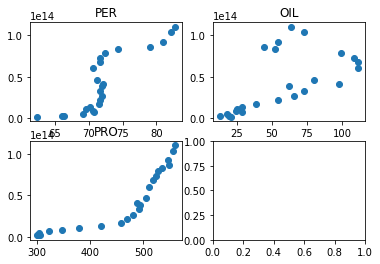

In [61]:
# Взглянем на диаграммы рассеяния 

fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(data.PER,data.GDP)
axs[0, 0].set_title('PER')
axs[0, 1].scatter(data.OIL,data.GDP)
axs[0, 1].set_title('OIL')
axs[1, 0].scatter(data.PRO,data.GDP)
axs[1, 0].set_title('PRO')

**Вывод**

Корреляции между фичами и целевым признаком невидно

In [62]:
X = data.drop('GDP',axis=1)
y = data.GDP

In [63]:
lin = lm.LinearRegression()
lin.fit(X, y)

print(lin.score(X, y))

0.8593379671356124


In [64]:
ridge = lm.Ridge()
ridge.fit(X, y)

print(ridge.score(X, y))

0.8593337343587598


In [65]:
# Лучшая
pois = lm.PoissonRegressor()
pois.fit(X, y)

print(pois.score(X, y))

0.9747754534301896


In [66]:
pois = lm.ElasticNet()
pois.fit(X, y)

print(pois.score(X, y))

0.8588145024264435


**Вывод**

Лучшую точность показала пуассоновская регрессия (или же лог-линейная регрессия). Думаю это связано с тем, что распределение нашой выборки ближе к распределению Пуассона, чем к Гауссову распределению

Модель считаю точной

**Также нужно проверить предпосылки о гомоскедостичности**

In [67]:
results = smf.ols('GDP ~ PER + OIL + PRO', data=data).fit()

In [68]:
# тест Гольдфельда-Квандта
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(results.resid, results.model.exog)
lzip(name, test)

[('F statistic', 5.593858715326296), ('p-value', 0.012590362430542186)]

In [69]:
# тест Бройша-Пагана
name = ['F statistic', 'p-value']
test = sms.het_breuschpagan(results.resid, results.model.exog)
lzip(name, test)

[('F statistic', 7.971864766008298), ('p-value', 0.046596768988980436)]

**Вывод**

Можно заметить, что модель устойчивая к гетероскедастичности

**И наконец проверим предпосылки об автокорреляции**

In [70]:
statsmodels.stats.stattools.durbin_watson(results.resid, axis=0)

0.274719298241711

In [71]:
_, __, F, pv = statsmodels.stats.diagnostic.acorr_lm(results.resid, nlags=None, autolag='AIC')
print('F статистика - {}, p-value - {}'.format(round(F, 2),round(pv, 2)))

F статистика - 9.8, p-value - 0.0


/home/romes_papa/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:622: FutureWarning: The default value of nlags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setmaxlags or period to silence this warning.
  warnings.warn("The default value of nlags is changing.  After 0.12, "
/home/romes_papa/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:645: FutureWarning: autolag is deprecated and will be removed after 0.12. Model selection before testing fails to control test size. Set autolag to False to silence this warning.
  warnings.warn("autolag is deprecated and will be removed after 0.12. "


**Вывод**

Можно заметить, что автокорреляция отсутсвует

**Тестовый прогноз**

In [72]:
# Смоделируем данные в соответствии с условием
test = X.iloc[23]

test[0] = 44.46
test[1] = 92
test[2] = test[2] - 9*(test[2]/100)

test_target = y.iloc[23] - 6*(y.iloc[23]/100)

In [73]:
test_result = pois.predict(np.asarray(test).reshape(1,3))

In [74]:
# Ошибка прогноза 
abs(test_result[0] - test_target)

19745928672770.75

# Выводы

1. Выборка ближе к распределению Пуассона
2. Автокорреляция отуствует
3. Гетероскедостичность отсутствует 